Connectivity

Running experiment with base nodes=50, edge prob=0.3, trials=5

RESULTS:

BASE GRAPH:
  Time: 0.034977 seconds
  Memory: 0.128174 MB

DOUBLE_NODES GRAPH:
  Time: 0.428172 seconds
  Memory: 0.377655 MB

DOUBLE_EDGES GRAPH:
  Time: 0.036807 seconds
  Memory: 0.128174 MB

DOUBLE_BOTH GRAPH:
  Time: 0.441224 seconds
  Memory: 0.377655 MB


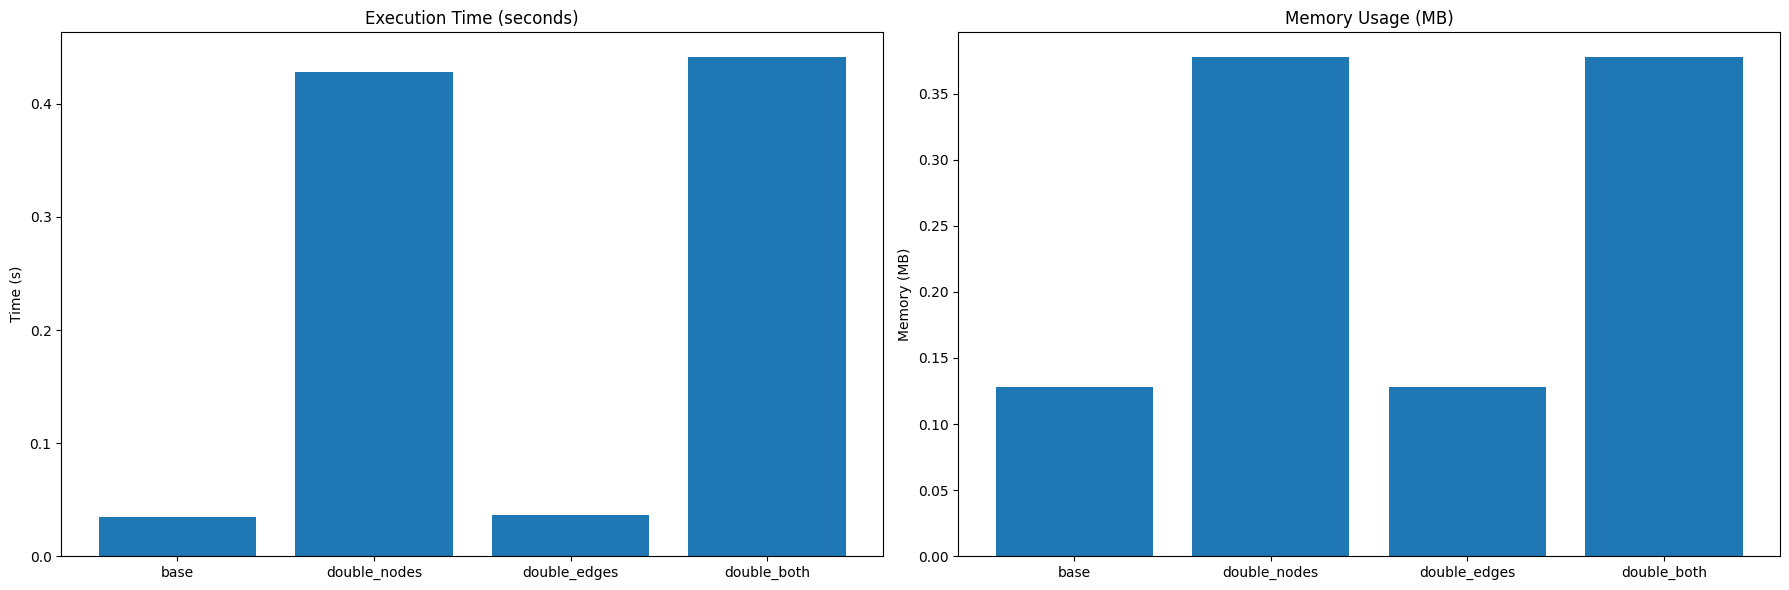

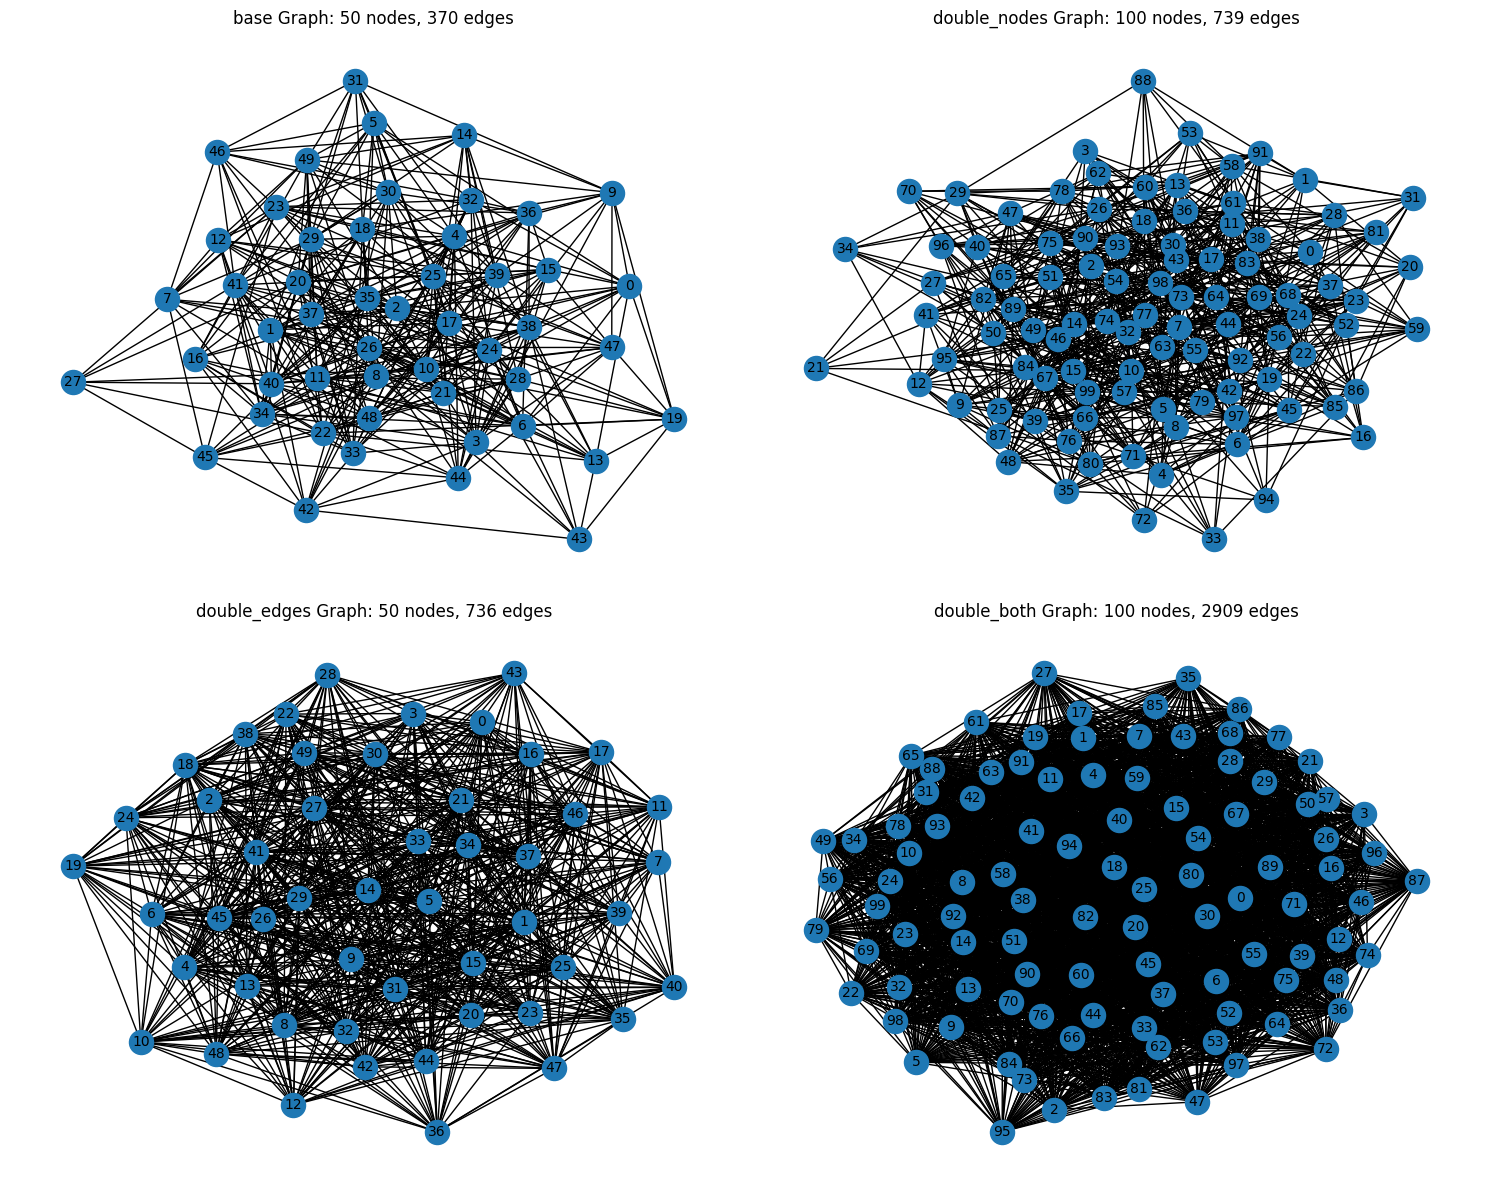

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import random
from scipy.sparse import csr_matrix
import seaborn as sns

class GraphSketch:
    def __init__(self, n_nodes, t=None):
        """
        Initialize the sketch for graph connectivity
        n_nodes: Number of nodes in the graph
        t: Number of random strings (O(log n))
        """
        self.n_nodes = n_nodes
        self.n_edges = n_nodes * (n_nodes - 1) // 2  # Maximum possible edges
        
        # If t not provided, set it to O(log n)
        if t is None:
            self.t = int(np.ceil(np.log2(n_nodes))) + 2
        else:
            self.t = t
            
        # k is the dimension of each sketch (O(log^2 n))
        self.k = int(np.ceil(np.log2(n_nodes)**2)) + 10
        
        # Initialize random projection matrices for 0-sampling
        # Each Mr is a k x n_edges matrix
        self.projection_matrices = []
        for _ in range(self.t):
            # Using random {-1, 1} entries for the projection matrix
            M_r = np.random.choice([-1, 1], size=(self.k, self.n_edges))
            self.projection_matrices.append(M_r)
    
    def edge_to_index(self, i, j):
        """Convert an edge (i, j) to its position in the edge vector"""
        if i > j:
            i, j = j, i  # Ensure i < j for consistency
        return (i * (2 * self.n_nodes - i - 1)) // 2 + (j - i - 1)
    
    def create_node_vector(self, node, edges):
        """
        Create the vector representation for a node as described in the paper
        node: Node index
        edges: List of edges in the graph
        """
        vector = np.zeros(self.n_edges)
        
        for u, v in edges:
            if u > v:
                u, v = v, u  # Ensure u < v for consistency
                
            # If this edge is connected to our node
            if u == node or v == node:
                idx = self.edge_to_index(u, v)
                if idx < self.n_edges:  # Safety check
                    vector[idx] = 1
                    
        return vector
    
    def compute_sketches(self, graph):
        """
        Compute the sketches for all nodes in the graph
        graph: NetworkX graph object
        """
        edges = list(graph.edges())
        node_sketches = {}
        
        for node in range(self.n_nodes):
            # Create the vector representation for this node
            node_vector = self.create_node_vector(node, edges)
            
            # Apply the random projections to get the sketch
            node_sketch = []
            for M_r in self.projection_matrices:
                projection = M_r @ node_vector
                node_sketch.append(projection)
                
            node_sketches[node] = node_sketch
            
        return node_sketches
    
    def zero_sample(self, sketch_sum):
        """
        Perform 0-sampling to find a non-zero entry
        sketch_sum: Sum of sketches from which to sample
        Returns: Index of sampled non-zero entry, or None if no non-zero entry
        """
        # This is a simplified version of 0-sampling
        # In practice, more sophisticated techniques would be used
        non_zero_indices = np.where(np.abs(sketch_sum) > 1e-10)[0]
        
        if len(non_zero_indices) == 0:
            return None
            
        # Sample uniformly from non-zero entries
        sampled_idx = np.random.choice(non_zero_indices)
        return sampled_idx
    
    def sketch_connectivity(self, node_sketches):
        """
        Use the sketches to determine graph connectivity
        node_sketches: Dictionary mapping nodes to their sketches
        """
        # Initial supernodes are individual nodes
        supernodes = [[node] for node in range(self.n_nodes)]
        
        # For each round of the algorithm
        for r in range(self.t):
            new_supernodes = []
            used_supernodes = set()
            
            # For each current supernode
            for i, supernode in enumerate(supernodes):
                if i in used_supernodes:
                    continue
                    
                # Compute the sketch sum for this supernode
                supernode_sketch_sum = np.zeros(self.k)
                for node in supernode:
                    supernode_sketch_sum += node_sketches[node][r]
                
                # Sample an edge to another supernode
                edge_idx = self.zero_sample(supernode_sketch_sum)
                
                if edge_idx is None:
                    # No edge to another supernode
                    new_supernodes.append(supernode)
                    continue
                
                # Find the other supernode connected by this edge
                found_match = False
                for j, other_supernode in enumerate(supernodes):
                    if i == j or j in used_supernodes:
                        continue
                        
                    other_sketch_sum = np.zeros(self.k)
                    for node in other_supernode:
                        other_sketch_sum += node_sketches[node][r]
                    
                    # If this edge connects to the other supernode
                    if np.abs(supernode_sketch_sum[edge_idx] + other_sketch_sum[edge_idx]) < 1e-10:
                        # Merge supernodes
                        new_supernode = supernode + other_supernode
                        new_supernodes.append(new_supernode)
                        used_supernodes.add(i)
                        used_supernodes.add(j)
                        found_match = True
                        break
                
                if not found_match and i not in used_supernodes:
                    new_supernodes.append(supernode)
            
            supernodes = new_supernodes
            
            # If only one supernode remains, the graph is connected
            if len(supernodes) == 1:
                return True, supernodes
        
        # After all rounds, check if there's only one supernode
        return len(supernodes) == 1, supernodes

def generate_random_graph(n_nodes, edge_probability=0.5):
    """Generate a random graph with n_nodes and random edges"""
    G = nx.gnp_random_graph(n_nodes, edge_probability)
    return G

def test_algorithm(G, sketch=None):
    """Test the graph connectivity algorithm on G"""
    n_nodes = G.number_of_nodes()
    
    # Create a new sketch if not provided
    if sketch is None:
        sketch = GraphSketch(n_nodes)
    
    start_time = time.time()
    node_sketches = sketch.compute_sketches(G)
    is_connected, components = sketch.sketch_connectivity(node_sketches)
    end_time = time.time()
    
    # Calculate memory usage (approximate)
    memory_usage = 0
    for node, node_sketch in node_sketches.items():
        for projection in node_sketch:
            memory_usage += projection.size * projection.itemsize
    
    # Calculate actual connectivity for accuracy comparison
    actual_connected = nx.is_connected(G)
    accuracy = 1 if is_connected == actual_connected else 0
    
    return {
        'time': end_time - start_time,
        'memory': memory_usage / (1024 * 1024),  # Convert to MB
        'is_connected': is_connected,
        'actual_connected': actual_connected
    }

def compare_graph_variations(base_nodes=10, base_edge_prob=0.3, trials=5):
    """
    Compare performance across different graph variations:
    1. Double nodes, same edge density
    2. Same nodes, double edge density
    3. Double both
    """
    results = {
        'base': {'time': [], 'memory': []},
        'double_nodes': {'time': [], 'memory': []},
        'double_edges': {'time': [], 'memory': []},
        'double_both': {'time': [], 'memory': []}
    }
    
    # Store example graphs for visualization
    example_graphs = {}
    
    for trial in range(trials):
        # Base case
        G_base = generate_random_graph(base_nodes, base_edge_prob)
        base_result = test_algorithm(G_base)
        results['base']['time'].append(base_result['time'])
        results['base']['memory'].append(base_result['memory'])
        
        if trial == 0:
            example_graphs['base'] = G_base
        
        # Double nodes
        G_double_nodes = generate_random_graph(base_nodes * 2, base_edge_prob / 2)
        double_nodes_result = test_algorithm(G_double_nodes)
        results['double_nodes']['time'].append(double_nodes_result['time'])
        results['double_nodes']['memory'].append(double_nodes_result['memory'])
        
        if trial == 0:
            example_graphs['double_nodes'] = G_double_nodes
        
        # Double edges (increase edge probability)
        edge_prob_double = min(1.0, base_edge_prob * 2)
        G_double_edges = generate_random_graph(base_nodes, edge_prob_double)
        double_edges_result = test_algorithm(G_double_edges)
        results['double_edges']['time'].append(double_edges_result['time'])
        results['double_edges']['memory'].append(double_edges_result['memory'])
        
        if trial == 0:
            example_graphs['double_edges'] = G_double_edges
        
        # Double both
        G_double_both = generate_random_graph(base_nodes * 2, edge_prob_double)
        double_both_result = test_algorithm(G_double_both)
        results['double_both']['time'].append(double_both_result['time'])
        results['double_both']['memory'].append(double_both_result['memory'])
        
        if trial == 0:
            example_graphs['double_both'] = G_double_both
    
    # Average results
    for key in results:
        for metric in results[key]:
            results[key][metric] = np.mean(results[key][metric])
    
    return results, example_graphs

def plot_results(results):
    """Plot the comparison results"""
    # Set up the figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Extract data
    labels = list(results.keys())
    times = [results[key]['time'] for key in labels]
    memories = [results[key]['memory'] for key in labels]
    
    # Plot time
    axes[0].bar(labels, times)
    axes[0].set_title('Execution Time (seconds)')
    axes[0].set_ylabel('Time (s)')
    
    # Plot memory
    axes[1].bar(labels, memories)
    axes[1].set_title('Memory Usage (MB)')
    axes[1].set_ylabel('Memory (MB)')
    
    plt.tight_layout()
    return fig

def visualize_graphs(example_graphs):
    """Visualize the example graphs from each test case"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Flatten axes for easy access
    axes = axes.flatten()
    
    # Plot each graph
    for i, (key, G) in enumerate(example_graphs.items()):
        ax = axes[i]
        pos = nx.spring_layout(G)
        nx.draw_networkx(G, pos=pos, ax=ax, node_size=300, font_size=10)
        ax.set_title(f"{key} Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
        ax.axis('off')
    
    plt.tight_layout()
    return fig

# Run the experiment
base_nodes = 50
base_edge_prob = 0.3
trials = 5

print(f"Running experiment with base nodes={base_nodes}, edge prob={base_edge_prob}, trials={trials}")
results, example_graphs = compare_graph_variations(base_nodes, base_edge_prob, trials)

# Display results
print("\nRESULTS:")
for key, metrics in results.items():
    print(f"\n{key.upper()} GRAPH:")
    print(f"  Time: {metrics['time']:.6f} seconds")
    print(f"  Memory: {metrics['memory']:.6f} MB")

# Plot the results
result_fig = plot_results(results)

# Visualize the example graphs
graph_fig = visualize_graphs(example_graphs)

plt.show()

K - Connectivity

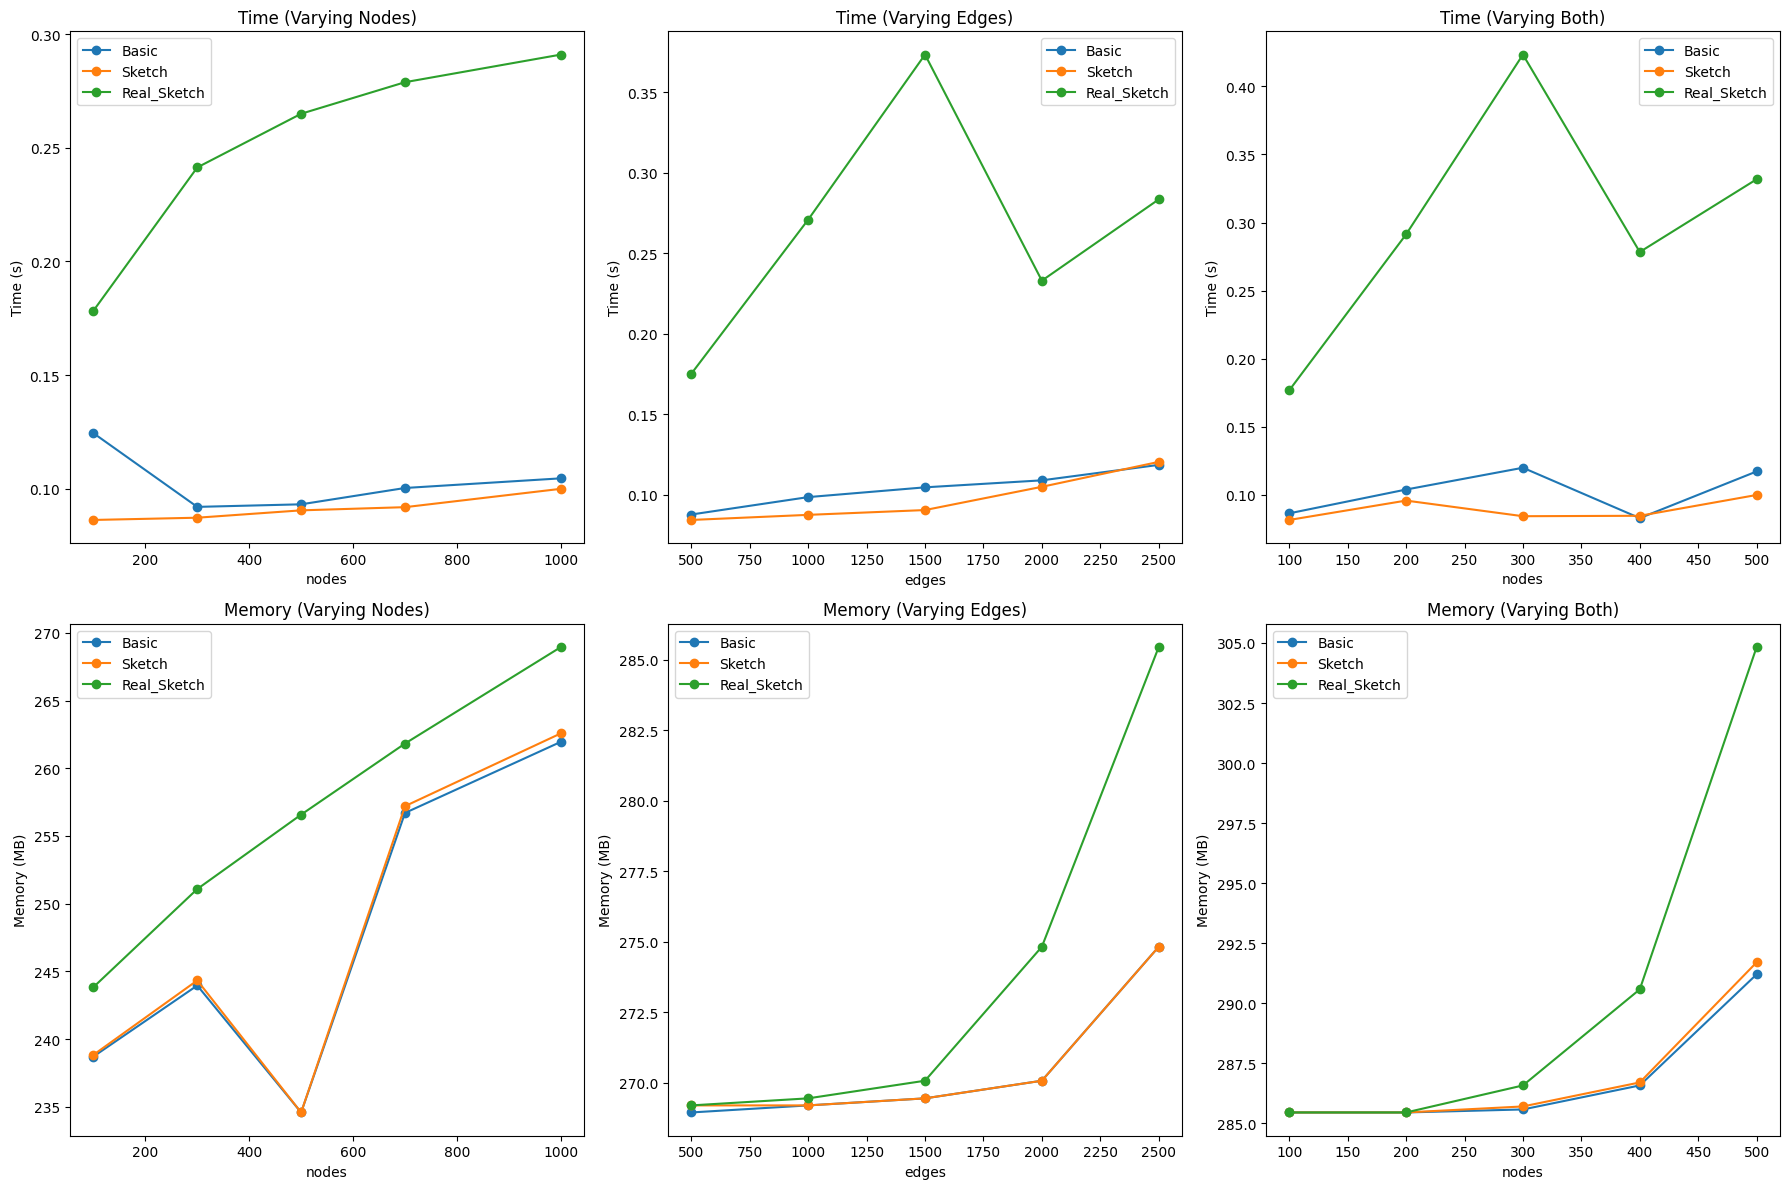

In [2]:
class DisjointSetForest:
    def __init__(self):
        """Initialize an empty disjoint-set forest."""
        self.parent = {}
        self.rank = {}
        
    def add_node(self, x):
        """Add a new node to the forest."""
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0
        
    def find(self, x):
        """Find the root of the set containing x with path compression."""
        if x not in self.parent:
            self.add_node(x)
            return x
            
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
        
    def union(self, x, y):
        """Unite the sets containing x and y."""
        x_root = self.find(x)
        y_root = self.find(y)
        
        if x_root == y_root:
            return
            
        if self.rank[x_root] < self.rank[y_root]:
            self.parent[x_root] = y_root
        else:
            self.parent[y_root] = x_root
            if self.rank[x_root] == self.rank[y_root]:
                self.rank[x_root] += 1

class StreamingKEdgeConnectivity:
    def __init__(self, k):
        """
        Initialize a streaming k-edge-connectivity algorithm based on Algorithm 2
        from "Lecture 1: Graph Streaming" paper.
        
        Args:
            k: Edge-connectivity parameter
        """
        self.k = k
        self.vertex_to_id = {}
        self.id_to_vertex = {}
        self.next_id = 0
        self.forests = [DisjointSetForest() for _ in range(k)]
        self.edges_in_forests = [set() for _ in range(k)]
        
    def _get_vertex_id(self, v):
        """Map a vertex to a consecutive ID."""
        if v not in self.vertex_to_id:
            self.vertex_to_id[v] = self.next_id
            self.id_to_vertex[self.next_id] = v
            self.next_id += 1
            
            # Add the new node to all forests
            for forest in self.forests:
                forest.add_node(self.vertex_to_id[v])
        
        return self.vertex_to_id[v]
    
    def process_edge(self, u, v):
        """
        Process a single edge from the stream.
        
        This follows Algorithm 2 from the paper:
        For any edge e in the stream, if there is any forest Fi such that
        Fi ∪ {e} has no cycle, add e to this Fi.
        """
        u_id = self._get_vertex_id(u)
        v_id = self._get_vertex_id(v)
        
        for i in range(self.k):
            # If adding this edge doesn't create a cycle in the i-th forest, add it
            if self.forests[i].find(u_id) != self.forests[i].find(v_id):
                self.forests[i].union(u_id, v_id)
                self.edges_in_forests[i].add((min(u_id, v_id), max(u_id, v_id)))
                return
    
    def get_forest_edges(self, i):
        """Get the edges in the i-th forest."""
        return [(self.id_to_vertex[u], self.id_to_vertex[v]) for u, v in self.edges_in_forests[i]]
    
    def get_certificate(self):
        """
        Get the certificate for k-edge-connectivity.
        This certificate is the union of the k disjoint forests.
        """
        certificate = set()
        for i in range(self.k):
            certificate.update(self.edges_in_forests[i])
        
        # Convert back to original vertex IDs
        return [(self.id_to_vertex[u], self.id_to_vertex[v]) for u, v in certificate]
    
    def is_connected(self):
        """Check if the graph is connected based on the first forest."""
        if self.next_id <= 1:
            return True
            
        root = self.forests[0].find(0)
        for i in range(1, self.next_id):
            if self.forests[0].find(i) != root:
                return False
        
        return True
    
    def is_k_edge_connected(self):
        """Check if the graph is k-edge-connected based on the certificate."""
        # If we have fewer than 2 nodes, any graph is k-edge-connected
        if self.next_id <= 1:
            return True
            
        # For each forest, check if it is a spanning tree
        for i in range(self.k):
            if not self._is_spanning_tree(i):
                return False
        
        return True
    
    def _is_spanning_tree(self, i):
        """Check if the i-th forest is a spanning tree."""
        # A spanning tree has exactly n-1 edges and connects all vertices
        n = self.next_id
        if len(self.edges_in_forests[i]) != n - 1:
            return False
            
        # Check if all vertices are in the same component
        root = self.forests[i].find(0)
        for j in range(1, n):
            if self.forests[i].find(j) != root:
                return False
                
        return True

def streaming_k_edge_connectivity(file_path, k, format='csv'):
    """Process a graph file in a streaming fashion to check k-edge-connectivity."""
    algorithm = StreamingKEdgeConnectivity(k)
    
    if format == 'csv':
        with open(file_path, 'r') as f:
            # Skip header if present
            header = f.readline()
            try:
                vals = header.strip().split(',')
                u, v = int(vals[0]), int(vals[1])
                algorithm.process_edge(u, v)
            except (ValueError, IndexError):
                # Header wasn't a valid edge
                pass
            
            # Process the rest of the file
            for line in f:
                try:
                    vals = line.strip().split(',')
                    u, v = int(vals[0]), int(vals[1])
                    algorithm.process_edge(u, v)
                except (ValueError, IndexError):
                    # Skip invalid lines
                    pass
    
    elif format == 'json':
        import json
        with open(file_path, 'r') as f:
            data = json.load(f)
            if isinstance(data, list):
                for item in data:
                    if 'source' in item and 'target' in item:
                        algorithm.process_edge(item['source'], item['target'])
            elif isinstance(data, dict) and 'edges' in data:
                for edge in data['edges']:
                    if 'source' in edge and 'target' in edge:
                        algorithm.process_edge(edge['source'], edge['target'])
    
    return {
        'is_connected': algorithm.is_connected(),
        'is_k_edge_connected': algorithm.is_k_edge_connected(),
        'vertex_count': algorithm.next_id,
        'certificate': algorithm.get_certificate()
    }

def analyze_graph_structure(file_path, format='csv'):
    """Analyze the structure of a graph in a streaming fashion."""
    edge_count = 0
    vertex_set = set()
    degree = {}
    
    # Process the file
    if format == 'csv':
        with open(file_path, 'r') as f:
            # Skip header if present
            header = f.readline()
            try:
                vals = header.strip().split(',')
                u, v = int(vals[0]), int(vals[1])
                vertex_set.add(u)
                vertex_set.add(v)
                degree[u] = degree.get(u, 0) + 1
                degree[v] = degree.get(v, 0) + 1
                edge_count += 1
            except (ValueError, IndexError):
                pass
            
            for line in f:
                try:
                    vals = line.strip().split(',')
                    u, v = int(vals[0]), int(vals[1])
                    vertex_set.add(u)
                    vertex_set.add(v)
                    degree[u] = degree.get(u, 0) + 1
                    degree[v] = degree.get(v, 0) + 1
                    edge_count += 1
                except (ValueError, IndexError):
                    pass
    
    elif format == 'json':
        import json
        with open(file_path, 'r') as f:
            data = json.load(f)
            if isinstance(data, list):
                for item in data:
                    if 'source' in item and 'target' in item:
                        u, v = item['source'], item['target']
                        vertex_set.add(u)
                        vertex_set.add(v)
                        degree[u] = degree.get(u, 0) + 1
                        degree[v] = degree.get(v, 0) + 1
                        edge_count += 1
            elif isinstance(data, dict) and 'edges' in data:
                for edge in data['edges']:
                    if 'source' in edge and 'target' in edge:
                        u, v = edge['source'], edge['target']
                        vertex_set.add(u)
                        vertex_set.add(v)
                        degree[u] = degree.get(u, 0) + 1
                        degree[v] = degree.get(v, 0) + 1
                        edge_count += 1
    
    # Calculate statistics
    vertex_count = len(vertex_set)
    density = (2 * edge_count) / (vertex_count * (vertex_count - 1)) if vertex_count > 1 else 0
    max_degree = max(degree.values()) if degree else 0
    min_degree = min(degree.values()) if degree else 0
    avg_degree = sum(degree.values()) / vertex_count if vertex_count > 0 else 0
    
    return {
        'vertex_count': vertex_count,
        'edge_count': edge_count,
        'density': density,
        'max_degree': max_degree,
        'min_degree': min_degree,
        'avg_degree': avg_degree
    }

import time
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import urllib.request
from io import BytesIO
from memory_profiler import memory_usage

def benchmark_streaming_algorithm(datasets, k_values):
    """Benchmark the streaming k-edge-connectivity algorithm on multiple datasets."""
    results = []
    
    for dataset_name, config in datasets.items():
        print(f"Processing dataset: {dataset_name}")
        
        # Download and extract the dataset if not already available
        dataset_dir = f"./data/{dataset_name}"
        if not os.path.exists(dataset_dir):
            download_and_extract_dataset(config['url'], dataset_dir)
        
        # Process each file in the dataset
        for file_name in config['files']:
            file_path = os.path.join(dataset_dir, file_name)
            
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            
            # Analyze graph structure
            print(f"  Analyzing graph structure...")
            structure = analyze_graph_structure(file_path, config['format'])
            
            for k in k_values:
                print(f"  Testing k = {k}")
                
                # Measure time
                start_time = time.time()
                result = streaming_k_edge_connectivity(file_path, k, config['format'])
                end_time = time.time()
                
                results.append({
                    'dataset': dataset_name,
                    'file': file_name,
                    'k': k,
                    'is_connected': result['is_connected'],
                    'is_k_edge_connected': result['is_k_edge_connected'],
                    'time_seconds': end_time - start_time,
                    'vertex_count': structure['vertex_count'],
                    'edge_count': structure['edge_count'],
                    'density': structure['density'],
                    'max_degree': structure['max_degree'],
                    'min_degree': structure['min_degree'],
                    'avg_degree': structure['avg_degree']
                })
    
    return pd.DataFrame(results)

import networkx as nx

def k_edge_connectivity_basic(G, k):
    """
    Basic algorithm to test if the graph G is at least k-edge-connected.
    Returns True if yes, otherwise False.
    """
    remaining_edges = set(G.edges())
    all_forests = []

    for i in range(k):
        # Create a subgraph without the edges already used in previous forests
        subG = nx.Graph()
        subG.add_nodes_from(G.nodes())
        subG.add_edges_from(remaining_edges)

        # Find a spanning forest in subG
        forest = nx.minimum_spanning_edges(subG, data=False)
        Fi = set(forest)
        all_forests.append(Fi)

        # Remove edges of the found forest from the remaining edge set
        remaining_edges -= Fi

    # Union of all forests
    union_forest = set().union(*all_forests)
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    H.add_edges_from(union_forest)

    # If H is not connected or is missing some cut, then it's not k-edge-connected
    return nx.is_k_edge_connected(H, k)

class Sketch:
    def __init__(self, G):
        self.edges = set(G.edges())

    def subtract(self, other):
        self.edges -= other.edges

    def get_spanning_forest(self):
        tempG = nx.Graph()
        tempG.add_edges_from(self.edges)
        return Sketch.from_edges(nx.minimum_spanning_edges(tempG, data=False))

    @classmethod
    def from_edges(cls, edges):
        s = cls(nx.Graph())  # empty graph
        s.edges = set(edges)
        return s


def k_edge_connectivity_sketch(G, k):
    """
    Sketch-emulated algorithm for testing k-edge-connectivity.
    """
    sketches = [Sketch(G) for _ in range(k)]
    forests = []

    for i in range(k):
        # Subtract previous forests from the current sketch
        for j in range(i):
            sketches[i].subtract(forests[j])

        # Get new forest from the current sketch
        Fi = sketches[i].get_spanning_forest()
        forests.append(Fi)

    # Combine all forests into a single graph and check k-edge-connectivity
    final_graph = nx.Graph()
    final_graph.add_nodes_from(G.nodes())
    for forest in forests:
        final_graph.add_edges_from(forest.edges)

    return nx.is_k_edge_connected(final_graph, k)

import numpy as np
import networkx as nx
import random
from collections import defaultdict


class GraphSketch:
    def __init__(self, num_nodes, dim=64, seed=None):
        self.n = num_nodes
        self.d = dim
        self.sketch = np.zeros((self.n, self.d))
        self.hashes = {}
        self.rng = np.random.default_rng(seed)

    def _edge_to_vector(self, u, v):
        """
        Returns a random vector representation for an edge (u, v).
        Uses signed random projections.
        """
        if (u, v) not in self.hashes and (v, u) not in self.hashes:
            vec = self.rng.choice([-1, 1], size=self.d)
            self.hashes[(u, v)] = vec
            self.hashes[(v, u)] = -vec
        return self.hashes[(u, v)]

    def add_edge(self, u, v):
        vec = self._edge_to_vector(u, v)
        self.sketch[u] += vec
        self.sketch[v] -= vec  # maintains flow conservation

    def remove_edge(self, u, v):
        vec = self._edge_to_vector(u, v)
        self.sketch[u] -= vec
        self.sketch[v] += vec

    def add_graph(self, G):
        for u, v in G.edges():
            self.add_edge(u, v)

    def subtract(self, other):
        self.sketch -= other.sketch

    def copy(self):
        new = GraphSketch(self.n, self.d)
        new.sketch = self.sketch.copy()
        new.hashes = self.hashes
        return new

    def recover_spanning_forest(self, all_edges):
        """
        Greedy sparse recovery: choose edges that help connect components and have significant sketch signal.
        """
        forest = []
        uf = UnionFind(self.n)
        for u, v in sorted(all_edges, key=lambda e: -self.edge_score(e[0], e[1])):
            if uf.find(u) != uf.find(v):
                forest.append((u, v))
                uf.union(u, v)
        return forest

    def edge_score(self, u, v):
        """
        Computes a rough score of how much the edge (u, v) appears in the sketch.
        Higher means more likely it's still in the sketch.
        """
        vec = self._edge_to_vector(u, v)
        score = np.dot(self.sketch[u], vec) - np.dot(self.sketch[v], vec)
        return abs(score)


class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))

    def find(self, x):
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x

    def union(self, x, y):
        xr = self.find(x)
        yr = self.find(y)
        if xr != yr:
            self.parent[yr] = xr


def k_edge_connectivity_sketch_real(G, k, dim=512):
    n = G.number_of_nodes()
    all_edges = list(G.edges())
    sketches = [GraphSketch(n, dim, seed=i) for i in range(k)]

    # Step 1: Create k independent sketches of G
    for sketch in sketches:
        sketch.add_graph(G)

    forests = []
    removed_edges = set()

    for i in range(k):
        # Subtract previous forests from sketch[i]
        for j in range(i):
            sketches[i].subtract(forests[j]['sketch'])

        # Recover a forest
        forest_edges = sketches[i].recover_spanning_forest(all_edges)

        # Save the sketch of this forest
        forest_sketch = GraphSketch(n, dim)
        for u, v in forest_edges:
            forest_sketch.add_edge(u, v)

        forests.append({'edges': forest_edges, 'sketch': forest_sketch})
        removed_edges.update(forest_edges)

    # Combine all edges from forests
    combined_graph = nx.Graph()
    combined_graph.add_nodes_from(G.nodes())
    for f in forests:
        combined_graph.add_edges_from(f['edges'])

    return nx.is_k_edge_connected(combined_graph, k)

import time
import psutil
import pandas as pd
import networkx as nx
from memory_profiler import memory_usage


def measure_algorithm(algorithm_fn, G, k):
    """
    Measure execution time and memory usage of an algorithm.
    """
    start_time = time.time()
    mem_usage = memory_usage((algorithm_fn, (G, k)), max_usage=True)
    end_time = time.time()

    result = algorithm_fn(G, k)
    return {
        'result': result,
        'time': end_time - start_time,
        'memory': mem_usage
    }

def generate_or_load_graph(dataset_name='karate'):
    """
    Load a graph dataset or generate one.
    """
    if dataset_name == 'karate':
        return nx.karate_club_graph()
    elif dataset_name == 'erdos_renyi':
        return nx.erdos_renyi_graph(n=100, p=0.1)
    elif dataset_name == 'complete':
        return nx.complete_graph(20)
    elif dataset_name == 'grid':
        return nx.grid_2d_graph(10, 10)
    else:
        raise ValueError("Unknown dataset")
    
import networkx as nx
import time
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from memory_profiler import memory_usage

def benchmark_datasets(datasets, algorithms, k_values):
    results = []
    for dataset_name, config in datasets.items():
        G = load_dataset(dataset_name, config)
        if G is None:
            continue
        for k in k_values:
            for algo_name, algo in algorithms.items():
                try:
                    mem_usage, ret = memory_usage((algo, (G, k)), retval=True, max_usage=True)
                    results.append({
                        'dataset': dataset_name,
                        'k': k,
                        'algorithm': algo_name,
                        'time': ret['time'],
                        'memory': mem_usage,
                        'nodes': G.number_of_nodes(),
                        'edges': G.number_of_edges()
                    })
                except Exception as e:
                    print(f"Error with {algo_name} on {dataset_name}: {str(e)}")
    return pd.DataFrame(results)

def generate_synthetic_graphs(base_nodes=100, base_edges=500):
    graphs = {}
    for n in [100, 300, 500, 700, 1000]:
        p = base_edges / (n*(n-1)/2)
        G = nx.erdos_renyi_graph(n, p)
        graphs[f'nodes_{n}'] = G
    for m in [500, 1000, 1500, 2000, 2500]:
        G = nx.gnm_random_graph(100, m)
        graphs[f'edges_{m}'] = G
    for scale in [1, 2, 3, 4, 5]:
        n = 100 * scale
        m = 500 * scale
        G = nx.gnm_random_graph(n, m)
        graphs[f'both_{scale}'] = G
    return graphs

def benchmark_synthetic(algorithms, k=2):
    results = []
    graphs = generate_synthetic_graphs()
    for graph_name, G in graphs.items():
        for algo_name, algo in algorithms.items():
            try:
                start = time.time()
                mem = memory_usage((algo, (G, k)), interval=0.1, timeout=120)
                elapsed = time.time() - start
                results.append({
                    'graph': graph_name,
                    'algorithm': algo_name,
                    'time': elapsed,
                    'max_memory': max(mem),
                    'nodes': G.number_of_nodes(),
                    'edges': G.number_of_edges()
                })
            except Exception as e:
                print(f"Error with {algo_name} on {graph_name}: {str(e)}")
    return pd.DataFrame(results)

def plot_comparison(df, x_col, group_col, title, pos):
    ax = plt.subplot(2, 3, pos)
    ax2 = plt.subplot(2, 3, pos+3)
    
    for algo in df['algorithm'].unique():
        subset = df[df['algorithm'] == algo]
        ax.plot(subset[x_col], subset['time'], label=algo, marker='o')
        ax2.plot(subset[x_col], subset['max_memory'], label=algo, marker='o')
    
    ax.set_title(f'Time ({title})')
    ax.set_xlabel(x_col)
    ax.set_ylabel('Time (s)')
    ax.legend()
    
    ax2.set_title(f'Memory ({title})')
    ax2.set_xlabel(x_col)
    ax2.set_ylabel('Memory (MB)')
    ax2.legend()

if __name__ == "__main__":
    algorithms = {
        'Basic': k_edge_connectivity_basic,
        'Sketch': k_edge_connectivity_sketch,
        'Real_Sketch': k_edge_connectivity_sketch_real
    }
    
    synthetic_results = benchmark_synthetic(algorithms)
    
    node_variation = synthetic_results[synthetic_results['graph'].str.startswith('nodes')]
    edge_variation = synthetic_results[synthetic_results['graph'].str.startswith('edges')]
    both_variation = synthetic_results[synthetic_results['graph'].str.startswith('both')]
    
    plt.figure(figsize=(18, 12))
    plot_comparison(node_variation, 'nodes', 'algorithm', 'Varying Nodes', 1)
    plot_comparison(edge_variation, 'edges', 'algorithm', 'Varying Edges', 2)
    plot_comparison(both_variation, 'nodes', 'algorithm', 'Varying Both', 3)
    plt.tight_layout()
    plt.show()


Sparsification

Processing facebook dataset…
  Extracting facebook…
  Loaded facebook: 20779 nodes, 100000 edges
Processing twitch dataset…
  Extracting twitch…
  Loaded twitch: 72821 nodes, 100000 edges
Processing deezer dataset…
  Extracting deezer…
  Loaded deezer: 363 nodes, 20732 edges

Initializing graph sparsifier…

Running sparsification experiments…

=== FACEBOOK ===
  Applying uniform_sampling @ 0.1 on facebook…
  Applying uniform_sampling @ 0.2 on facebook…
  Applying uniform_sampling @ 0.5 on facebook…
  Applying karger_sampling @ 0.1 on facebook…
  Applying karger_sampling @ 0.2 on facebook…
  Applying karger_sampling @ 0.5 on facebook…
  Applying fung_sampling @ 0.1 on facebook…
  Applying fung_sampling @ 0.2 on facebook…
  Applying fung_sampling @ 0.5 on facebook…
  Applying spectral_sparsification @ 0.1 on facebook…
  Applying spectral_sparsification @ 0.2 on facebook…
  Applying spectral_sparsification @ 0.5 on facebook…
  Applying skeleton_sparsification @ 0.1 on facebook…
  Applying

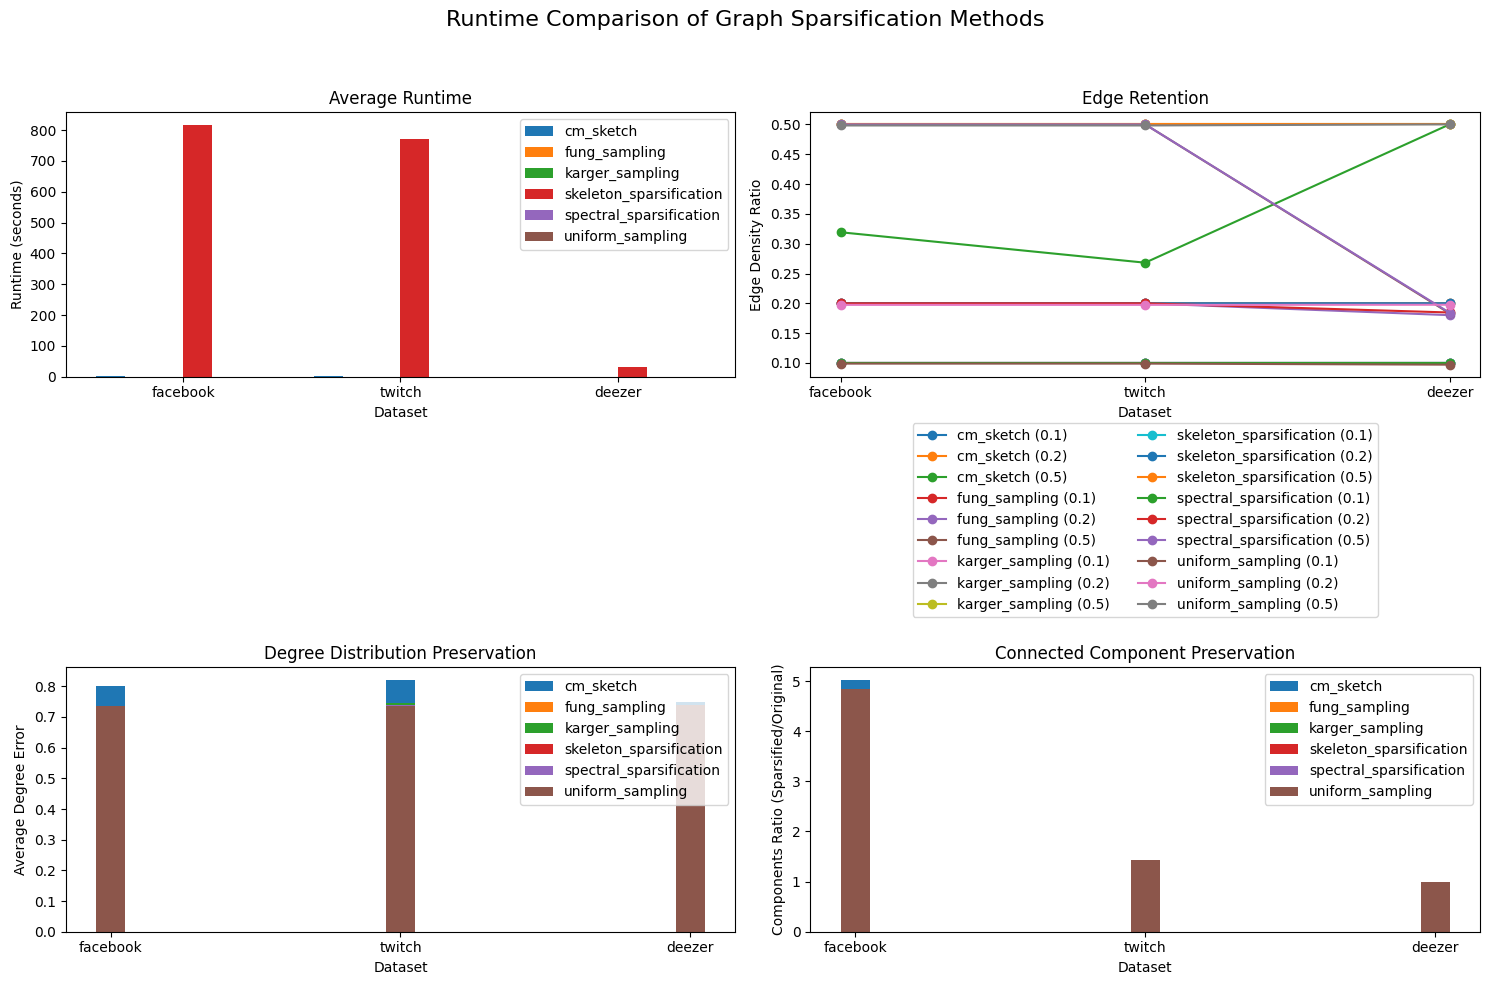

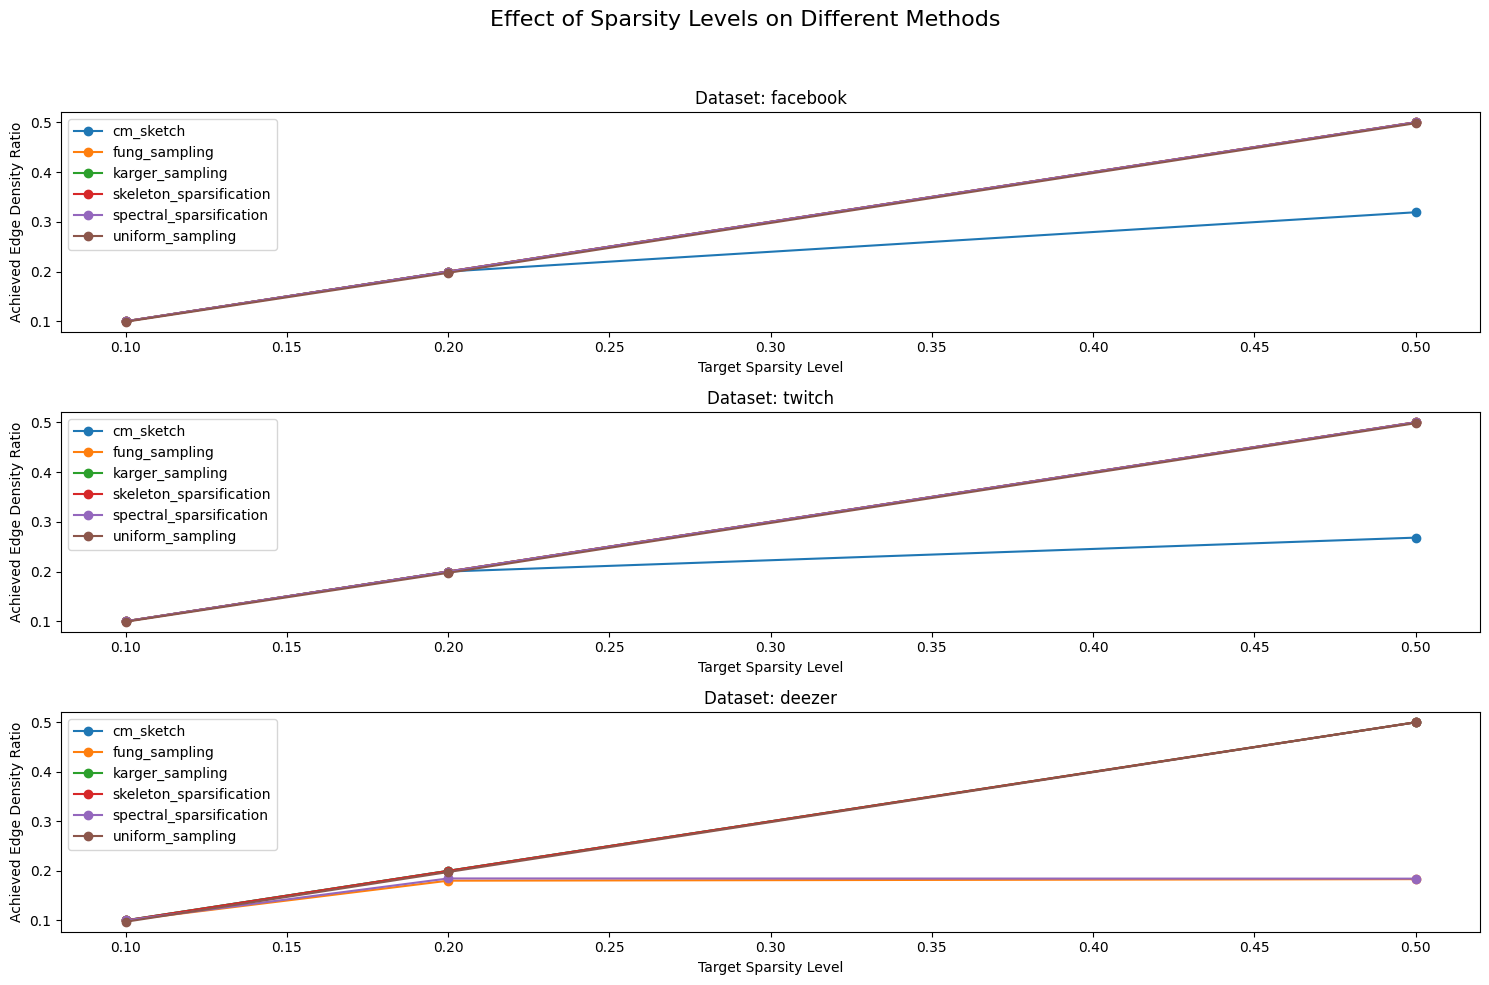

In [ ]:
import os
import json
import time
import gzip
import tarfile
import zipfile
import urllib.request
import multiprocessing as mp
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


class GraphSparsifier:
    """
    Implements various graph sparsification algorithms.
    """
    def __init__(self):
        self.stats = {}

    def uniform_sampling(self, edges, p):
        start = time.time()
        sampled, weights = [], []
        for u, v in edges:
            if np.random.random() < p:
                sampled.append((u, v))
                weights.append(1/p)
        self.stats['uniform_sampling'] = {
            'runtime': time.time() - start,
            'edges_kept': len(sampled),
            'sampling_probability': p
        }
        return sampled, weights

    def karger_sampling(self, graph, edges, c=3.0):
        start = time.time()
        degrees = dict(graph.degree())
        min_cut = min(degrees.values()) if degrees else 1
        p = min(1.0, c * np.log(graph.number_of_nodes()) / min_cut)
        sampled, weights = [], []
        for u, v in edges:
            if np.random.random() < p:
                sampled.append((u, v))
                weights.append(1/p)
        self.stats['karger_sampling'] = {
            'runtime': time.time() - start,
            'edges_kept': len(sampled),
            'min_cut': min_cut,
            'sampling_probability': p
        }
        return sampled, weights

    def fung_sampling(self, graph, edges, c=3.0):
        start = time.time()
        degrees = dict(graph.degree())
        n = graph.number_of_nodes()
        logn = np.log(n) if n > 1 else 1.0
        sampled, weights = [], []
        for u, v in edges:
            conn = max(1, min(degrees.get(u,1), degrees.get(v,1)))
            p = min(1.0, c * logn / conn)
            if np.random.random() < p:
                sampled.append((u, v))
                weights.append(1/p)
        self.stats['fung_sampling'] = {
            'runtime': time.time() - start,
            'edges_kept': len(sampled)
        }
        return sampled, weights

    def spectral_sparsification(self, graph, edges, eps=0.1):
        start = time.time()
        degrees = dict(graph.degree())
        n = graph.number_of_nodes()
        logn = np.log(n) if n > 1 else 1.0
        sampled, weights = [], []
        for u, v in edges:
            min_deg = max(1, min(degrees.get(u,1), degrees.get(v,1)))
            approx_res = 1.0 / min_deg
            p = min(1.0, 3.0 * logn * approx_res)
            if np.random.random() < p:
                sampled.append((u, v))
                weights.append(1/p)
        self.stats['spectral_sparsification'] = {
            'runtime': time.time() - start,
            'edges_kept': len(sampled)
        }
        return sampled, weights

    def skeleton_sparsification(self, graph, edges, k=3):
        start = time.time()
        max_i = min(5, int(np.log2(graph.number_of_edges())) + 1)
        sampled, weights = [], []
        for i in range(max_i):
            p_i = 1.0 / (2**i)
            subset = edges
            if len(edges) > 100_000:
                idx = np.random.choice(len(edges), min(100_000, int(p_i*len(edges))), replace=False)
                subset = [edges[j] for j in idx]
            for u, v in subset:
                if (u, v) not in sampled and np.random.random() < p_i:
                    sampled.append((u, v))
                    weights.append(1/p_i)
        self.stats['skeleton_sparsification'] = {
            'runtime': time.time() - start,
            'edges_kept': len(sampled),
            'k_value': k
        }
        return sampled, weights

    def cm_sketch(self, graph, edges, width=1000, depth=5):
        start = time.time()
        sketch = np.zeros((depth, width), dtype=float)
        hash_funcs = [lambda x, i=i: hash(f"{x}_{i}") % width for i in range(depth)]
        for u, v in edges:
            for node in (u, v):
                for i, hf in enumerate(hash_funcs):
                    sketch[i, hf(node)] += 1
        node_degs = {
            node: min(sketch[i, hf(node)] for i, hf in enumerate(hash_funcs))
            for u, v in edges for node in (u, v)
        }
        max_deg = max(node_degs.values()) if node_degs else 1
        sampled, weights = [], []
        for u, v in edges:
            p = max(0.01, min(1.0, max(node_degs.get(u,0), node_degs.get(v,0)) / max_deg))
            if np.random.random() < p:
                sampled.append((u, v))
                weights.append(1/p)
        self.stats['cm_sketch'] = {
            'runtime': time.time() - start,
            'edges_kept': len(sampled),
            'sketch_width': width,
            'sketch_depth': depth
        }
        return sampled, weights


def download_and_prepare_datasets():
    """
    Download and prepare Facebook, Twitch, and Deezer datasets.
    """
    datasets = {
        'facebook': {
            'url': 'https://snap.stanford.edu/data/facebook_large.zip',
            'files': ['musae_facebook_edges.csv'],
            'format': 'csv'
        },
        'twitch': {
            'url': 'https://snap.stanford.edu/data/twitch_gamers.zip',
            'files': ['large_twitch_edges.csv'],
            'format': 'csv'
        },
        'deezer': {
            'url': 'https://snap.stanford.edu/data/deezer_ego_nets.zip',
            'files': ['deezer_edges'],
            'format': 'json'
        }
    }

    os.makedirs('data', exist_ok=True)
    processed = {}

    for name, info in datasets.items():
        print(f"Processing {name} dataset…")
        archive = os.path.join('data', os.path.basename(info['url']))
        if not os.path.exists(archive):
            print(f"  Downloading {name}…")
            urllib.request.urlretrieve(info['url'], archive)

        print(f"  Extracting {name}…")
        try:
            if archive.endswith('.tar.gz'):
                with tarfile.open(archive, 'r:gz') as t:
                    t.extractall('data')
            elif archive.endswith('.zip'):
                with zipfile.ZipFile(archive, 'r') as z:
                    z.extractall('data')
            elif archive.endswith('.gz'):
                out = os.path.join('data', info['files'][0])
                with gzip.open(archive, 'rb') as f_in, open(out, 'wb') as f_out:
                    f_out.write(f_in.read())
        except Exception as e:
            print(f"  Extraction error: {e}")
            continue

        # Locate edge file
        edge_fp = None
        for root, _, files in os.walk('data'):
            for f in files:
                base, _ = os.path.splitext(f)
                if info['format']=='csv' and f in info['files']:
                    edge_fp = os.path.join(root, f)
                    break
                if info['format']=='json' and 'deezer_edges' in base:
                    edge_fp = os.path.join(root, f)
                    break
            if edge_fp:
                break

        if not edge_fp:
            print(f"  Could not locate edges file for {name}")
            continue

        G = nx.Graph()
        try:
            if info['format'] == 'csv':
                df = pd.read_csv(edge_fp)
                if {'from','to'}.issubset(df.columns):
                    ucol, vcol = 'from','to'
                elif {'source','target'}.issubset(df.columns):
                    ucol, vcol = 'source','target'
                else:
                    ucol, vcol = df.columns[:2]
                G.add_edges_from(zip(df[ucol], df[vcol]))

            else:  # JSON
                with open(edge_fp, 'r') as f:
                    data = json.load(f)
                # Flatten per-ego edge lists if needed
                if isinstance(data, dict) and 'edges' in data:
                    edges = data['edges']
                elif isinstance(data, list) and data and isinstance(data[0], list):
                    edges = data
                elif isinstance(data, dict):
                    edges = []
                    for v in data.values():
                        if isinstance(v, list) and v and isinstance(v[0], list):
                            edges.extend(v)
                    if not edges:
                        raise ValueError("JSON dict contains no list-of-pairs")
                else:
                    raise ValueError("Unrecognized JSON edges format")
                G.add_edges_from((int(u),int(v)) for u,v in edges)

            # Down-sample large graphs
            if G.number_of_edges() > 100_000:
                all_e = list(G.edges())
                idx = np.random.choice(len(all_e), 100_000, replace=False)
                sampled = [all_e[i] for i in idx]
                G = nx.Graph()
                G.add_edges_from(sampled)

            print(f"  Loaded {name}: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
            processed[name] = G

        except Exception as e:
            print(f"  Error loading graph: {e}")

    return processed


def evaluate_sparsifier(orig, sp_edges, weights):
    sp = nx.Graph()
    sp.add_edges_from(sp_edges)
    density = sp.number_of_edges() / max(1, orig.number_of_edges())
    orig_deg = dict(orig.degree())
    sp_deg   = dict(sp.degree())
    errs = [
        abs(orig_deg[n] - sp_deg.get(n,0)) / orig_deg[n]
        for n in list(orig_deg)[:1000] if orig_deg[n]>0
    ]
    return {
        'density_ratio': density,
        'average_degree_error': np.mean(errs) if errs else float('nan'),
        'original_components': nx.number_connected_components(orig),
        'sparsified_components': nx.number_connected_components(sp)
    }


def process_method(dataset_name, graph, method_name, func, level, edges):
    print(f"  Applying {method_name} @ {level} on {dataset_name}…")
    try:
        if method_name == 'uniform_sampling':
            sp_e, w = func(edges, p=level)
        else:
            sp_e, w = func(graph, edges)
            target = int(level * len(edges))
            if len(sp_e) > target:
                idx = np.random.choice(len(sp_e), target, replace=False)
                sp_e = [sp_e[i] for i in idx]
                w    = [w[i]   for i in idx]
        evals = evaluate_sparsifier(graph, sp_e, w)
        rt = func.__self__.stats.get(method_name, {}).get('runtime', 0)
        return {'edges_kept': len(sp_e), 'runtime': rt, 'evaluation': evals}
    except Exception as e:
        print(f"    Error: {e}")
        return None


def run_sparsification_experiment(datasets, sparsifier, methods=None, sparsity_levels=None):
    if methods is None:
        methods = [
            'uniform_sampling', 'karger_sampling', 'fung_sampling',
            'spectral_sparsification', 'skeleton_sparsification', 'cm_sketch'
        ]
    if sparsity_levels is None:
        sparsity_levels = [0.1, 0.2, 0.5]

    results = {}
    for name, G in datasets.items():
        print(f"\n=== {name.upper()} ===")
        results[name] = {}
        edges = list(G.edges())
        pool = mp.Pool(processes=min(mp.cpu_count(), len(methods)*len(sparsity_levels)))
        for m in methods:
            results[name][m] = {}
            func = getattr(sparsifier, m)
            tasks = [(name, G, m, func, lvl, edges) for lvl in sparsity_levels]
            outs = pool.starmap(process_method, tasks)
            for lvl, out in zip(sparsity_levels, outs):
                if out:
                    results[name][m][lvl] = out
        pool.close()
        pool.join()
    return results


def visualize_results(results):
    """
    Create visualizations to compare the different sparsification methods.
    """
    # Extract method names and dataset names
    methods = set()
    datasets = list(results.keys())
    
    for dataset in results.values():
        methods.update(dataset.keys())
    
    methods = sorted(methods)
    
    # Create figures
    plt.figure(figsize=(15, 10))
    plt.suptitle('Runtime Comparison of Graph Sparsification Methods', fontsize=16)
    
    # Runtime comparison
    plt.subplot(2, 2, 1)
    x = np.arange(len(datasets))
    width = 0.8 / len(methods)
    
    for i, method in enumerate(methods):
        runtimes = []
        for dataset in datasets:
            # Get average runtime across sparsity levels
            method_results = results[dataset].get(method, {})
            if not method_results:
                runtimes.append(0)
                continue
                
            runtime_sum = 0
            count = 0
            
            for level_result in method_results.values():
                if level_result:
                    runtime_sum += level_result.get('runtime', 0)
                    count += 1
                
            avg_runtime = runtime_sum / count if count > 0 else 0
            runtimes.append(avg_runtime)
            
        plt.bar(x + i * width - 0.4 + width/2, runtimes, width, label=method)
    
    plt.xlabel('Dataset')
    plt.ylabel('Runtime (seconds)')
    plt.title('Average Runtime')
    plt.xticks(x, datasets)
    plt.legend()
    
    # Edge retention comparison
    plt.subplot(2, 2, 2)
    
    for i, method in enumerate(methods):
        for j, level in enumerate([0.1, 0.2, 0.5]):
            densities = []
            
            for dataset in datasets:
                method_results = results[dataset].get(method, {})
                level_result = method_results.get(level, {})
                
                if level_result and 'evaluation' in level_result:
                    density = level_result['evaluation'].get('density_ratio', 0)
                else:
                    density = 0
                    
                densities.append(density)
            
            plt.plot(datasets, densities, 'o-', label=f"{method} ({level})")
    
    plt.xlabel('Dataset')
    plt.ylabel('Edge Density Ratio')
    plt.title('Edge Retention')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    
    # Degree error comparison
    plt.subplot(2, 2, 3)
    
    for i, method in enumerate(methods):
        degree_errors = []
        
        for dataset in datasets:
            method_results = results[dataset].get(method, {})
            
            # Calculate average across sparsity levels
            error_sum = 0
            count = 0
            
            for level_result in method_results.values():
                if level_result and 'evaluation' in level_result and 'average_degree_error' in level_result['evaluation']:
                    error = level_result['evaluation']['average_degree_error']
                    if not np.isnan(error):
                        error_sum += error
                        count += 1
            
            avg_error = error_sum / count if count > 0 else float('nan')
            degree_errors.append(avg_error)
        
        # Filter out nan values
        valid_datasets = [datasets[i] for i in range(len(datasets)) if not np.isnan(degree_errors[i])]
        valid_errors = [e for e in degree_errors if not np.isnan(e)]
        
        if valid_datasets:
            plt.bar(valid_datasets, valid_errors, width=0.1, label=method)
    
    plt.xlabel('Dataset')
    plt.ylabel('Average Degree Error')
    plt.title('Degree Distribution Preservation')
    plt.legend()
    
    # Component ratio comparison
    plt.subplot(2, 2, 4)
    
    for i, method in enumerate(methods):
        component_ratios = []
        
        for dataset in datasets:
            method_results = results[dataset].get(method, {})
            
            # Calculate average across sparsity levels
            ratio_sum = 0
            count = 0
            
            for level_result in method_results.values():
                if level_result and 'evaluation' in level_result:
                    eval_data = level_result['evaluation']
                    if 'original_components' in eval_data and 'sparsified_components' in eval_data:
                        orig = eval_data['original_components']
                        sparse = eval_data['sparsified_components']
                        if orig > 0:
                            ratio = sparse / orig
                            ratio_sum += ratio
                            count += 1
            
            avg_ratio = ratio_sum / count if count > 0 else float('nan')
            component_ratios.append(avg_ratio)
        
        # Filter out nan values
        valid_datasets = [datasets[i] for i in range(len(datasets)) if not np.isnan(component_ratios[i])]
        valid_ratios = [r for r in component_ratios if not np.isnan(r)]
        
        if valid_datasets:
            plt.bar(valid_datasets, valid_ratios, width=0.1, label=method)
    
    plt.xlabel('Dataset')
    plt.ylabel('Components Ratio (Sparsified/Original)')
    plt.title('Connected Component Preservation')
    plt.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('sparsification_comparison.png', dpi=300, bbox_inches='tight')
    
    # Create sparsity level comparison plot
    plt.figure(figsize=(15, 10))
    plt.suptitle('Effect of Sparsity Levels on Different Methods', fontsize=16)
    
    sparsity_levels = [0.1, 0.2, 0.5]
    
    for dataset_idx, dataset in enumerate(datasets):
        plt.subplot(len(datasets), 1, dataset_idx + 1)
        
        for method in methods:
            runtimes = []
            densities = []
            
            for level in sparsity_levels:
                method_results = results[dataset].get(method, {})
                level_result = method_results.get(level, {})
                
                if level_result:
                    runtime = level_result.get('runtime', 0)
                    runtimes.append(runtime)
                    
                    if 'evaluation' in level_result:
                        density = level_result['evaluation'].get('density_ratio', 0)
                    else:
                        density = 0
                else:
                    runtime = 0
                    density = 0
                    
                densities.append(density)
            
            if any(d > 0 for d in densities):
                plt.plot(sparsity_levels, densities, 'o-', label=method)
        
        plt.xlabel('Target Sparsity Level')
        plt.ylabel('Achieved Edge Density Ratio')
        plt.title(f'Dataset: {dataset}')
        plt.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('sparsity_level_comparison.png', dpi=300, bbox_inches='tight')
    
    return


def main():
    print("Downloading and preparing datasets…")
    datasets = download_and_prepare_datasets()
    if not datasets:
        print("No datasets loaded. Exiting.")
        return

    print("\nInitializing graph sparsifier…")
    sparsifier = GraphSparsifier()

    methods = [
        'uniform_sampling', 'karger_sampling', 'fung_sampling',
        'spectral_sparsification', 'skeleton_sparsification', 'cm_sketch'
    ]
    levels = [0.1, 0.2, 0.5]

    print("\nRunning sparsification experiments…")
    results = run_sparsification_experiment(datasets, sparsifier,
                                            methods=methods,
                                            sparsity_levels=levels)

    print("\nExperiment complete. Summary:")
    for name, mdata in results.items():
        print(f"\n{name.upper()}:")
        for m, lvls in mdata.items():
            for lvl, info in lvls.items():
                print(f"  {m} @ {lvl}: rt={info['runtime']:.3f}s, "
                      f"kept={info['edges_kept']}, "
                      f"density={info['evaluation']['density_ratio']:.3f}")

    visualize_results(results)


if __name__ == "__main__":
    main()
